In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import typing as ty
from skimage import io
import cv2

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision.transforms as T
import random

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

import torchvision.transforms.functional as TF

import warnings
warnings.filterwarnings("ignore")

### Paso 1: Preparación de Datos y Configuración de Variables Iniciales

In [2]:
# Cargar anotaciones desde el archivo CSV
df_path     = r'G:\My Drive\af-ii-2024-ii-object-localization\train.csv'
images_path = r'G:\My Drive\af-ii-2024-ii-object-localization\images'

df = pd.read_csv(df_path)

# Visualizar las primeras filas para revisar el formato de los datos
display(df.head())

,filename,xmin,ymin,xmax,ymax,class_id,new_split
0,image_id_000_.jpg,303,506,25,36,1,train
1,image_id_001_.jpg,391,278,64,25,2,train
2,image_id_002_.jpg,313,425,54,37,2,train
3,image_id_003_.jpg,313,360,44,48,2,train
4,image_id_005_.jpg,298,254,49,53,2,train


In [3]:
# Tamaño real de la imagen y tamaño deseado para el procesamiento
hw_real = 640  # Tamaño real de las imágenes de entrada
h, w, c = 255, 255, 3  # Tamaño de transformación de las imágenes


# Reasignar class_id para tener 0: pingüino, 1: tortuga
df['class_id'] = np.where(df['class_id'] == 2, 1, 0)

# Diccionarios de mapeo de clases
obj2id = {
    "penguin": 0, 
    "turtle": 1
}

id2obj = {
    0: "penguin",
    1: "turtle"
}

# Ajustar xmax e ymax para representar las coordenadas máximas absolutas
df['xmax'] = df['xmin'] + df['xmax']
df['ymax'] = df['ymin'] + df['ymax']

# Crear una columna de 'class' mapeada desde 'class_id'
df["class"] = df["class_id"].map(id2obj)

# Mostrar una muestra del DataFrame modificado y normalizado
print("Muestra del DataFrame actualizado y normalizado:")
print(df.head())


Muestra del DataFrame actualizado y normalizado:
            filename  xmin  ymin  xmax  ymax  class_id new_split    class
0  image_id_000_.jpg   303   506   328   542         0     train  penguin
1  image_id_001_.jpg   391   278   455   303         1     train   turtle
2  image_id_002_.jpg   313   425   367   462         1     train   turtle
3  image_id_003_.jpg   313   360   357   408         1     train   turtle
4  image_id_005_.jpg   298   254   347   307         1     train   turtle


In [4]:

# Función para visualizar una imagen con su bounding box
def show_image_with_bbox(row):
    img_name = row['filename']
    try:
        img = Image.open(os.path.join(images_path, img_name))
    except FileNotFoundError:
        print(f"Error: La imagen {img_name} no se encuentra en la ruta especificada.")
        return

    # Crear la figura y el eje
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Crear un rectángulo para el bounding box
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    width, height = xmax - xmin, ymax - ymin
    color = 'r' if row['class_id'] == 1 else 'b'  # Rojo para pingüinos, azul para tortugas
    bbox = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    plt.show()


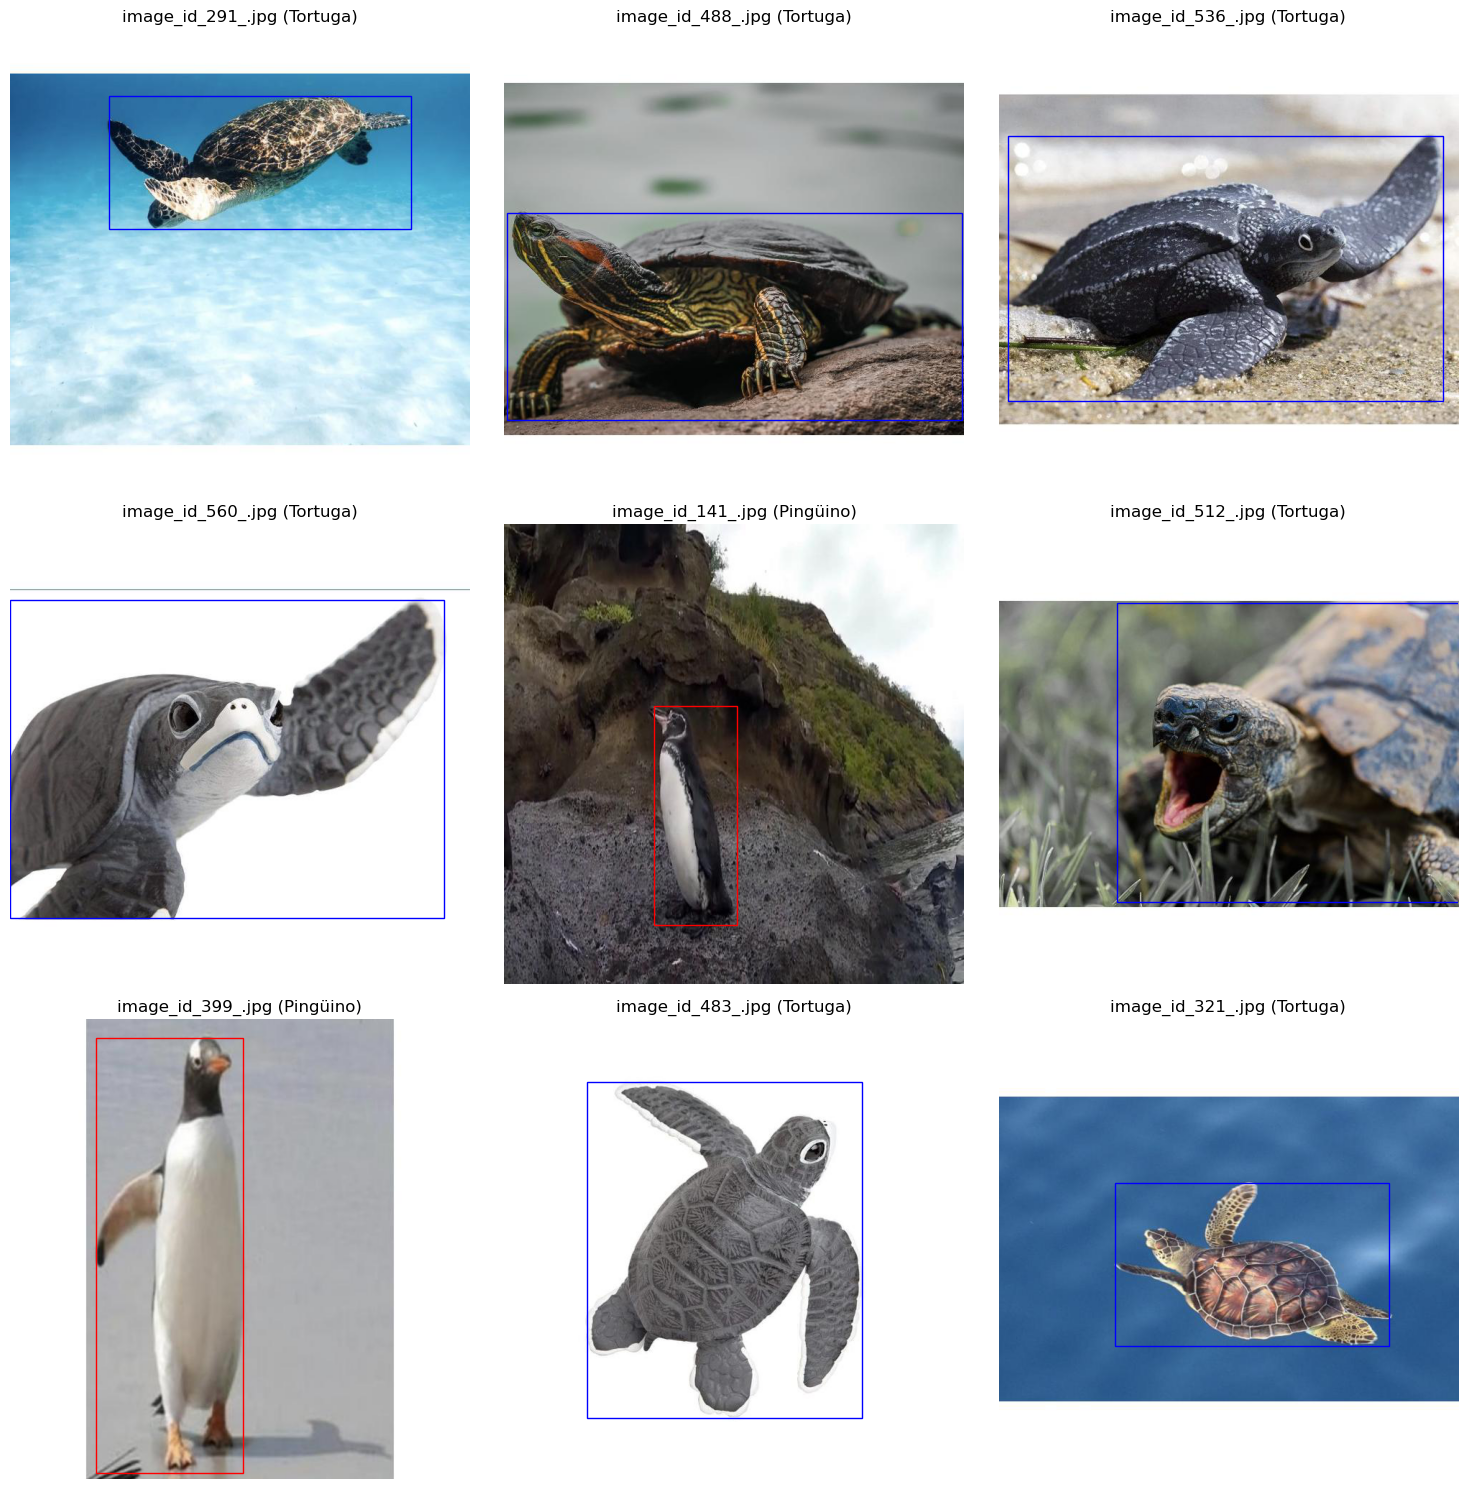

In [5]:
# Seleccionar 9 imágenes aleatorias
random_rows = df.sample(n=9)

# Imprimir las 9 imágenes aleatorias en una matriz de 3x3
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flatten()):
    row = random_rows.iloc[i]
    img_name = row['filename']
    try:
        img = Image.open(os.path.join(images_path, img_name))
        ax.imshow(img)
    except FileNotFoundError:
        ax.text(0.5, 0.5, 'Imagen no encontrada', ha='center', va='center')
        ax.axis('off')
        continue
    
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    width, height = xmax - xmin, ymax - ymin
    color = 'r' if row['class_id'] == 0 else 'b'  # Diferente color por clase
    bbox = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    ax.set_title(f"{img_name} ({'Pingüino' if row['class_id'] == 0 else 'Tortuga'})")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Normalizar los bounding boxes dividiendo por el tamaño real de la imagen
df[["xmin", "ymin", "xmax", "ymax"]] /= hw_real

In [7]:
df.head(5)

,filename,xmin,ymin,xmax,ymax,class_id,new_split,class
0,image_id_000_.jpg,0.473438,0.790625,0.512500,0.846875,0,train,penguin
1,image_id_001_.jpg,0.610938,0.434375,0.710938,0.473438,1,train,turtle
2,image_id_002_.jpg,0.489063,0.664062,0.573438,0.721875,1,train,turtle
3,image_id_003_.jpg,0.489063,0.562500,0.557813,0.637500,1,train,turtle
4,image_id_005_.jpg,0.465625,0.396875,0.542188,0.479687,1,train,turtle


### Paso 2: Definición de la Clase imageDataset

In [8]:

# Tipos de transformaciones y parámetros
transform_func_inp_signature = ty.Dict[str, np.ndarray]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class imageDataset(Dataset):
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Leer la imagen
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)

        # Ajustes de formato
        if image.ndim == 2:  
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  
            image = image[:, :, :3] 
        
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        
        sample = {'image': image}

        if self.labeled:
            # Cargar etiquetas
            img_class = self.df.class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 1:5].values.astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        # Aplicar transformaciones si existen
        if self.transform:
            sample = self.transform(sample)
        
        # Convertir imagen a tensor después de aplicar las transformaciones
        sample['image'] = TF.to_tensor(sample['image'])  # Convertir a tensor
        
        return sample


In [9]:

'''
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Leer la imagen
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)

        # Ajustes de formato
        if image.ndim == 2:  # Escala de grises
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # RGBA a RGB
            image = image[:, :, :3] 
        
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)  # Redimensionar a tamaño especificado
        
        sample = {'image': image}

        if self.labeled:
            # Cargar etiquetas: clase y bounding box
            img_class = self.df.class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 1:5].values.astype('float')
            img_class = np.array([img_class]).astype('int')

            # Añadir a sample
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        # Aplicar transformaciones, si existen
        if self.transform:
            sample = self.transform(sample)
        
        return sample'''

"\n    def __getitem__(self, idx: int) -> transform_func_signature: \n        if torch.is_tensor(idx):\n            idx = idx.tolist()\n        \n        # Leer la imagen\n        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])\n        image = io.imread(img_name)\n\n        # Ajustes de formato\n        if image.ndim == 2:  # Escala de grises\n            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)\n        elif image.shape[2] == 4:  # RGBA a RGB\n            image = image[:, :, :3] \n        \n        # Redimensionar la imagen si se especifica un tamaño de salida\n        if self.output_size:\n            image = cv2.resize(image, self.output_size)  # Redimensionar a tamaño especificado\n        \n        sample = {'image': image}\n\n        if self.labeled:\n            # Cargar etiquetas: clase y bounding box\n            img_class = self.df.class_id.iloc[idx]\n            img_bbox = self.df.iloc[idx, 1:5].values.astype('float')\n            img_class = np.ar

### Paso 3: Implementación de Técnicas de Data Augmentation

In [10]:
# Función de augmentación para una imagen y su bounding box
def data_augmentation(sample, prob=0.5):
    image = sample['image']
    bbox = sample['bbox']
    
    # 1. Flip horizontal con probabilidad de 50%
    if random.random() < prob:
        image = cv2.flip(image, 1)
        bbox[0], bbox[2] = 1 - bbox[2], 1 - bbox[0]

    # 2. Rotación aleatoria
    if random.random() < prob:
        angle = random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # 3. Ajuste de brillo
    if random.random() < prob:
        factor = 0.5 + random.uniform(0.5, 1.5)
        image = np.array(T.functional.adjust_brightness(T.ToPILImage()(image), factor))

    # 4. Ajuste de contraste
    if random.random() < prob:
        factor = 0.5 + random.uniform(0.5, 1.5)
        image = np.array(T.functional.adjust_contrast(T.ToPILImage()(image), factor))

    sample['image'] = image
    sample['bbox'] = bbox
    return sample

'''
def data_augmentation(sample, prob=0.5):
    image = sample['image']
    bbox = sample['bbox']
    
    # 1. Flip horizontal con probabilidad de 50%
    if random.random() < prob:
        image = cv2.flip(image, 1)
        # Ajuste del bounding box para el flip
        bbox[0], bbox[2] = 1 - bbox[2], 1 - bbox[0]

    # 2. Rotación aleatoria
    if random.random() < prob:
        angle = random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        # (Ajuste del bounding box se omite aquí por simplicidad)

    # 3. Ajuste de brillo
    if random.random() < prob:
        factor = 0.5 + random.uniform(0.5, 1.5)  # Factor entre 0.5 y 1.5
        image = T.functional.adjust_brightness(T.ToPILImage()(image), factor)
        image = np.array(image)

    # 4. Ajuste de contraste
    if random.random() < prob:
        factor = 0.5 + random.uniform(0.5, 1.5)
        image = T.functional.adjust_contrast(T.ToPILImage()(image), factor)
        image = np.array(image)

    sample['image'] = image
    sample['bbox'] = bbox
    return sample'''


"\ndef data_augmentation(sample, prob=0.5):\n    image = sample['image']\n    bbox = sample['bbox']\n    \n    # 1. Flip horizontal con probabilidad de 50%\n    if random.random() < prob:\n        image = cv2.flip(image, 1)\n        # Ajuste del bounding box para el flip\n        bbox[0], bbox[2] = 1 - bbox[2], 1 - bbox[0]\n\n    # 2. Rotación aleatoria\n    if random.random() < prob:\n        angle = random.randint(-15, 15)\n        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)\n        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))\n        # (Ajuste del bounding box se omite aquí por simplicidad)\n\n    # 3. Ajuste de brillo\n    if random.random() < prob:\n        factor = 0.5 + random.uniform(0.5, 1.5)  # Factor entre 0.5 y 1.5\n        image = T.functional.adjust_brightness(T.ToPILImage()(image), factor)\n        image = np.array(image)\n\n    # 4. Ajuste de contraste\n    if random.random() < prob:\n        factor = 0.5 + ran

### Paso 4: División del Conjunto de Datos

In [11]:
# Separar las instancias de pingüinos y tortugas
penguins = df[df['class_id'] == 0]
turtles = df[df['class_id'] == 1]

# Dividir cada clase en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_penguins, test_penguins = train_test_split(penguins, test_size=0.2, random_state=42)
train_turtles, test_turtles = train_test_split(turtles, test_size=0.2, random_state=42)

# Combinar las instancias de pingüinos y tortugas para crear los conjuntos finales
train_data = pd.concat([train_penguins, train_turtles]).sample(frac=1, random_state=42).reset_index(drop=True)
test_data = pd.concat([test_penguins, test_turtles]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el equilibrio de clases en cada conjunto
print("Distribución de clases en el conjunto de entrenamiento:")
print(train_data['class_id'].value_counts())

print("\nDistribución de clases en el conjunto de prueba:")
print(test_data['class_id'].value_counts())


Distribución de clases en el conjunto de entrenamiento:
class_id
1    189
0    189
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
class_id
1    48
0    48
Name: count, dtype: int64


In [12]:
train_data.head(5)

,filename,xmin,ymin,xmax,ymax,class_id,new_split,class
0,image_id_288_.jpg,0.173437,0.195312,0.676562,0.567187,1,train,turtle
1,image_id_520_.jpg,0.095312,0.198437,0.803125,0.906250,1,train,turtle
2,image_id_042_.jpg,0.482812,0.464062,0.618750,0.635938,1,train,turtle
3,image_id_475_.jpg,0.009375,0.376563,0.990625,0.806250,0,train,penguin
4,image_id_396_.jpg,0.193750,0.262500,0.735938,0.809375,0,train,penguin


### Paso 5: Definir train_dataset y test_dataset con Data Augmentation

In [13]:
# Definir el dataset de entrenamiento con data augmentation
train_dataset = imageDataset(
    df=train_data,
    root_dir=images_path,  # Usar images_path como el directorio de las imágenes
    labeled=True,
    transform=data_augmentation,  # Pasar la función de data augmentation
    output_size=(255, 255)  # Redimensionar las imágenes a 255x255
)

# Definir el dataset de prueba sin data augmentation
test_dataset = imageDataset(
    df=test_data,
    root_dir=images_path,  # Usar images_path como el directorio de las imágenes
    labeled=True,
    transform=None,  # Sin data augmentation en el conjunto de prueba
    output_size=(255, 255)  # Redimensionar las imágenes a 255x255
)


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Función para visualizar una muestra de imágenes con bounding boxes
def show_sample_images(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # Extraer la imagen, bounding box y clase
        image = sample['image']
        bbox = sample['bbox'] #[0]  #bbox está en el formato [xmin, ymin, xmax, ymax]
        class_id = sample['class_id'][0]
        
        # Convertir la imagen de tensor a numpy para visualización
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
        
        # Desnormalizar el bounding box (multiplicar por hw_real si fue normalizado)
        bbox = bbox * hw_real
        
        # Mostrar la imagen y el bounding box
        ax = axs[i]
        ax.imshow(image)
        xmin, ymin, xmax, ymax = bbox
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Añadir el título con la clase y el nombre de la imagen
        class_name = id2obj[class_id]
        ax.set_title(f'Class: {class_name}\nImage: {dataset.df.iloc[i]["filename"]}')
        ax.axis('off')
        print(f"Bounding box: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")
    
    plt.show()


Muestras del conjunto de entrenamiento:
Bounding box: xmin=111.0, ymin=125.0, xmax=433.0, ymax=363.0
Bounding box: xmin=61.0, ymin=127.0, xmax=514.0, ymax=580.0
Bounding box: xmin=309.0, ymin=297.0, xmax=396.0, ymax=407.0
Bounding box: xmin=6.000000000000014, ymin=241.0, xmax=634.0, ymax=516.0
Bounding box: xmin=124.0, ymin=168.0, xmax=471.0, ymax=518.0


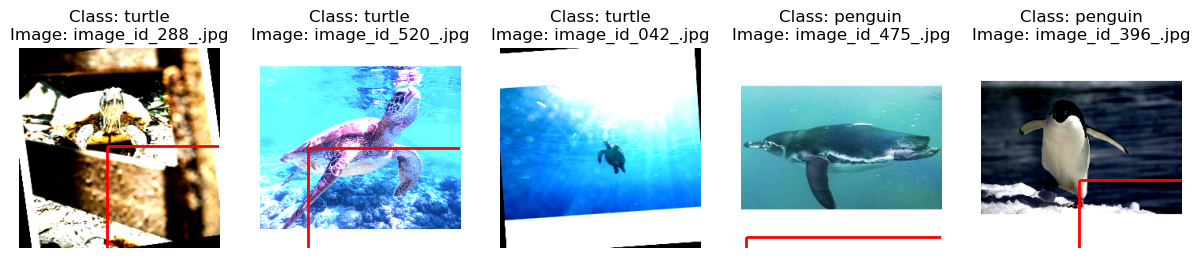


Muestras del conjunto de prueba:
Bounding box: xmin=2.0, ymin=89.0, xmax=640.0, ymax=562.0
Bounding box: xmin=162.0, ymin=319.0, xmax=319.0, ymax=426.0
Bounding box: xmin=73.0, ymin=153.0, xmax=518.0, ymax=616.0
Bounding box: xmin=67.0, ymin=313.0, xmax=409.0, ymax=391.0
Bounding box: xmin=521.0, ymin=263.0, xmax=591.0, ymax=418.0


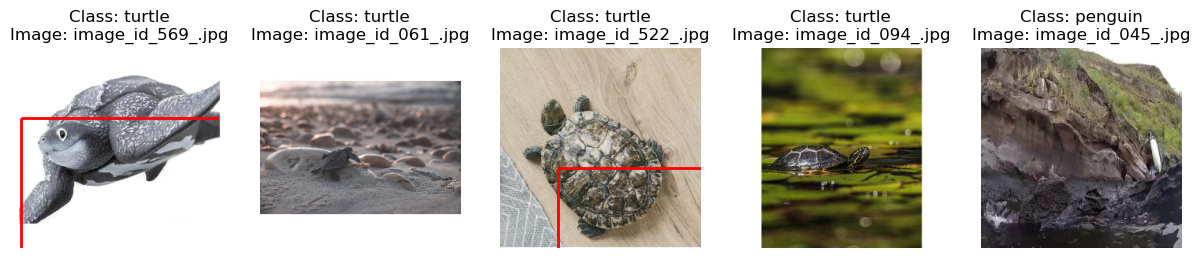

In [15]:

# Mostrar muestras del conjunto de entrenamiento con data augmentation
print("Muestras del conjunto de entrenamiento:")
show_sample_images(train_dataset)

# Mostrar muestras del conjunto de prueba sin data augmentation
print("\nMuestras del conjunto de prueba:")
show_sample_images(test_dataset)


### Paso 6: Configuración de DataLoaders para Procesamiento en GPU

In [16]:


# Configuración del dispositivo: usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configurar DataLoaders
batch_size = 32  # Puedes ajustar el tamaño del lote según la memoria de la GPU

# DataLoader para entrenamiento (con data augmentation)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Ajustar para procesamiento paralelo
    pin_memory=True if device.type == 'cuda' else False
)

# DataLoader para prueba (sin data augmentation)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)


Using device: cuda


### Paso 7: Definir el Modelo CNN Personalizado

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_conv_layers=6):
        super(CustomCNN, self).__init__()
        
        # Lista de capas convolucionales y de batch normalization
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        
        # Número de filtros inicial
        in_channels = 3
        out_channels = 32
        
        # Crear las capas convolucionales y de batch normalization
        for i in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bn_layers.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels
            out_channels *= 2  # Duplicar el número de filtros en cada capa
        
        # Max pooling para reducir el tamaño de las características
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calcular el tamaño de las características después de las capas convolucionales
        feature_size = 255 // (2 ** num_conv_layers)
        
        # Capas completamente conectadas para clasificación y regresión
        self.fc1 = nn.Linear(in_channels * feature_size * feature_size, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # Cabeza de clasificación
        self.fc_class = nn.Linear(256, 2)
        
        # Cabeza de regresión para bounding box
        self.fc_bbox = nn.Linear(256, 4)
        
    def forward(self, x):
        # Pasar por las capas convolucionales y de batch normalization
        for conv, bn in zip(self.conv_layers, self.bn_layers):
            x = self.pool(F.relu(bn(conv(x))))
        
        # Aplanar las características extraídas
        x = x.view(x.size(0), -1)
        
        # Pasar por las capas completamente conectadas
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Salidas para clasificación y bounding box
        class_output = self.fc_class(x)
        bbox_output = self.fc_bbox(x)
        
        return class_output, bbox_output

# Crear una instancia del modelo con un número específico de capas convolucionales y moverlo a la GPU
num_conv_layers = 5  # Ajusta este hiperparámetro para cambiar la profundidad
model = CustomCNN(num_conv_layers=num_conv_layers).to(device)
print(model)



CustomCNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Line

### Paso 8: Bucle de Entrenamiento del Modelo

In [19]:
import torch.optim as optim

# Configurar la función de pérdida y el optimizador
criterion_class = nn.CrossEntropyLoss()  # Pérdida para la clasificación
criterion_bbox = nn.MSELoss()            # Pérdida para el bounding box
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Puedes ajustar la tasa de aprendizaje

# Definir el número de épocas
num_epochs = 50  # Puedes ajustar este hiperparámetro según las necesidades del modelo

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()  # Poner el modelo en modo de entrenamiento
    running_loss = 0.0
    
    for batch in train_loader:
        # Obtener los datos y moverlos a GPU
        images = batch['image'].to(device, dtype=torch.float32)
        labels = batch['class_id'].squeeze().to(device, dtype=torch.long)
        bboxes = batch['bbox'].squeeze().to(device, dtype=torch.float32)
        
        # Forward pass
        class_outputs, bbox_outputs = model(images)
        
        # Calcular las pérdidas de clasificación y bounding box
        loss_class = criterion_class(class_outputs, labels)
        loss_bbox = criterion_bbox(bbox_outputs, bboxes)
        loss = loss_class + loss_bbox  # Pérdida total combinada
        
        # Backward pass y optimización
        optimizer.zero_grad()  # Limpiar gradientes
        loss.backward()        # Backpropagation
        optimizer.step()       # Actualizar pesos
        
        # Acumular la pérdida del lote
        running_loss += loss.item()
    
    # Imprimir la pérdida promedio por época
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Entrenamiento completado.")


Epoch [1/50], Loss: 0.9704
Epoch [2/50], Loss: 0.5129
Epoch [3/50], Loss: 0.3645
Epoch [4/50], Loss: 0.3446
Epoch [5/50], Loss: 0.3284
Epoch [6/50], Loss: 0.3355
Epoch [7/50], Loss: 0.3205
Epoch [8/50], Loss: 0.3594
Epoch [9/50], Loss: 0.3454
Epoch [10/50], Loss: 0.3128
Epoch [11/50], Loss: 0.2189
Epoch [12/50], Loss: 0.2441
Epoch [13/50], Loss: 0.2265
Epoch [14/50], Loss: 0.2472
Epoch [15/50], Loss: 0.2123
Epoch [16/50], Loss: 0.2683
Epoch [17/50], Loss: 0.2100
Epoch [18/50], Loss: 0.2259
Epoch [19/50], Loss: 0.3250
Epoch [20/50], Loss: 0.2274
Epoch [21/50], Loss: 0.1768
Epoch [22/50], Loss: 0.1854
Epoch [23/50], Loss: 0.1774
Epoch [24/50], Loss: 0.1739
Epoch [25/50], Loss: 0.1547
Epoch [26/50], Loss: 0.1957
Epoch [27/50], Loss: 0.1385
Epoch [28/50], Loss: 0.1322
Epoch [29/50], Loss: 0.1617
Epoch [30/50], Loss: 0.1210
Epoch [31/50], Loss: 0.1302
Epoch [32/50], Loss: 0.1301
Epoch [33/50], Loss: 0.1617
Epoch [34/50], Loss: 0.1832
Epoch [35/50], Loss: 0.1718
Epoch [36/50], Loss: 0.1500
E

### Paso 9: Evaluación del Modelo

In [20]:
from sklearn.metrics import accuracy_score

def calculate_iou(pred_box, true_box):
    """
    Calcula el Intersection over Union (IoU) entre dos cajas.
    """
    xA = max(pred_box[0], true_box[0])
    yA = max(pred_box[1], true_box[1])
    xB = min(pred_box[2], true_box[2])
    yB = min(pred_box[3], true_box[3])
    
    # Área de intersección
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # Área de predicción y verdad
    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
    
    # IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Evaluación del modelo
model.eval()  # Modo evaluación
all_labels = []
all_preds = []
ious = []

with torch.no_grad():
    for batch in test_loader:
        # Obtener los datos y moverlos a GPU
        images = batch['image'].to(device, dtype=torch.float32)
        labels = batch['class_id'].squeeze().to(device, dtype=torch.long)
        true_bboxes = batch['bbox'].squeeze().to(device, dtype=torch.float32) * hw_real  # Desnormalizar
        
        # Forward pass
        class_outputs, bbox_outputs = model(images)
        
        # Predicciones de clase
        _, preds = torch.max(class_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
        # Cálculo del IoU para cada bounding box
        for i in range(len(true_bboxes)):
            pred_bbox = bbox_outputs[i].cpu().numpy() * hw_real  # Desnormalizar la predicción
            true_bbox = true_bboxes[i].cpu().numpy()
            iou = calculate_iou(pred_bbox, true_bbox)
            ious.append(iou)

# Cálculo de las métricas
accuracy = accuracy_score(all_labels, all_preds)
mean_iou = sum(ious) / len(ious)

print(f"Accuracy de Clasificación: {accuracy:.4f}")
print(f"IoU Promedio de Bounding Boxes: {mean_iou:.4f}")


Accuracy de Clasificación: 0.9271
IoU Promedio de Bounding Boxes: 0.3807


### Paso 10: Desnormalización y Visualización de Resultados

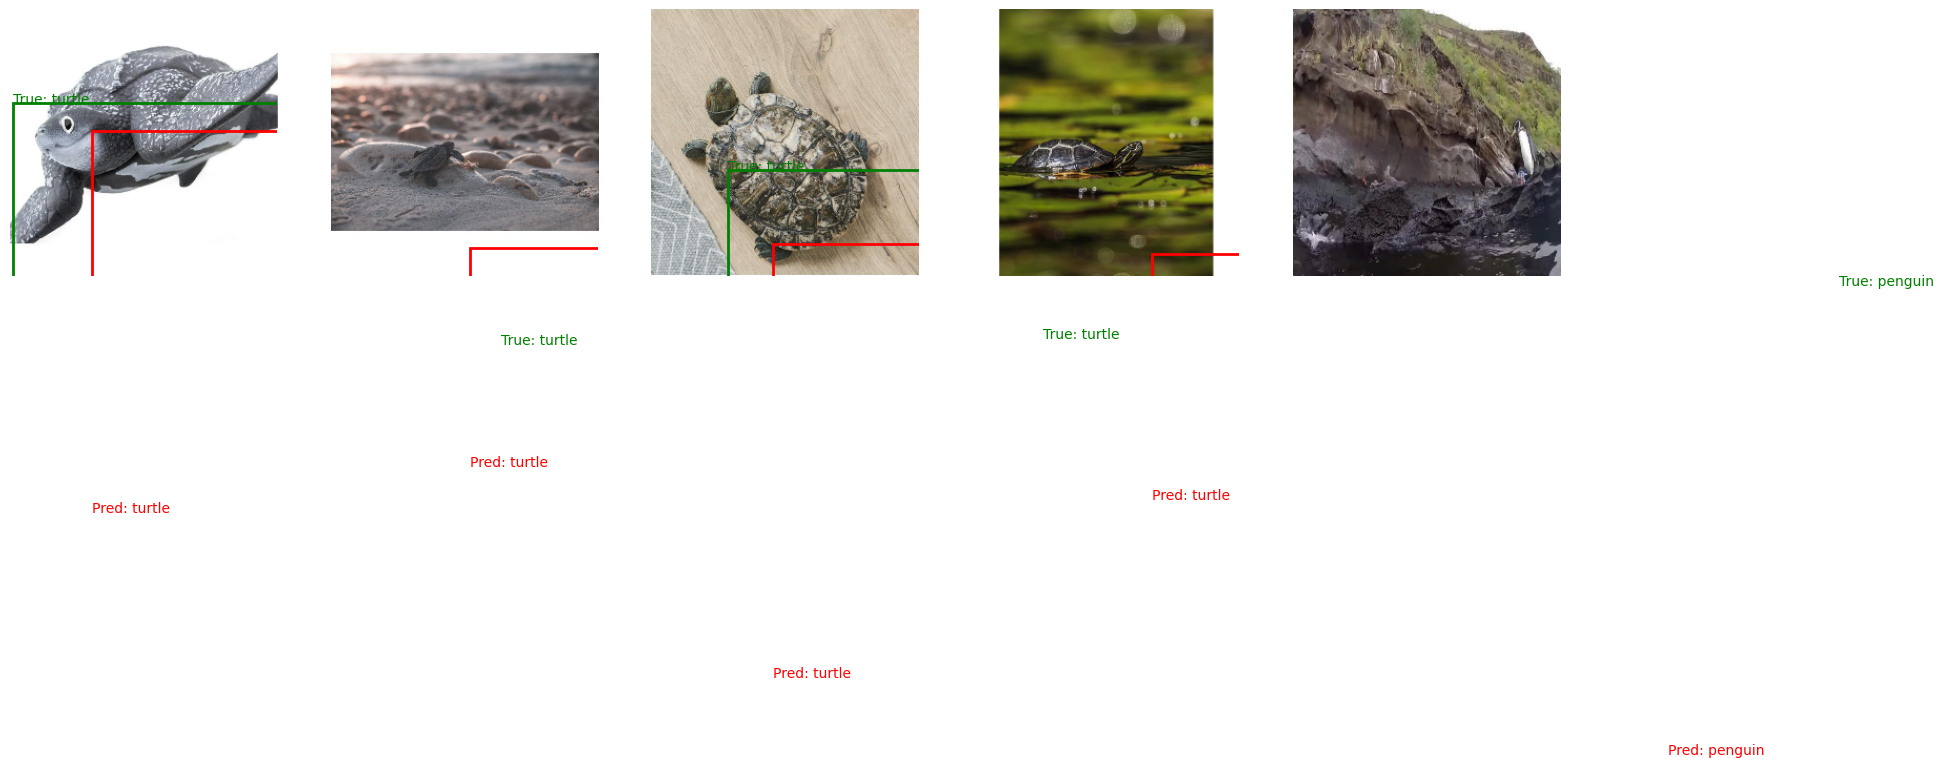

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_predictions(model, dataset, num_samples=5):
    model.eval()  # Modo evaluación
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            image = sample['image'].to(device).unsqueeze(0)  # Añadir batch dimension
            true_bbox = sample['bbox'] * hw_real  # Desnormalizar bounding box real
            true_class = sample['class_id'].item()
            
            # Forward pass para obtener las predicciones
            pred_class, pred_bbox = model(image)
            
            # Obtener predicción de clase y bounding box
            pred_class = torch.argmax(pred_class, dim=1).item()
            pred_bbox = (pred_bbox.squeeze().cpu().numpy()) * hw_real  # Desnormalizar predicción
            
            # Convertir imagen a formato numpy para visualización
            image = image.squeeze().cpu().permute(1, 2, 0).numpy()
            
            # Crear figura para la visualización
            ax = axs[i]
            ax.imshow(image)
            
            # Dibujar el bounding box real en verde
            xmin, ymin, xmax, ymax = true_bbox
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'True: {id2obj[true_class]}', color='g', fontsize=10)
            
            # Dibujar el bounding box predicho en rojo
            xmin, ymin, xmax, ymax = pred_bbox
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymax, f'Pred: {id2obj[pred_class]}', color='r', fontsize=10)
            
            ax.axis('off')
    
    plt.show()

# Mostrar algunas predicciones en el conjunto de prueba
show_predictions(model, test_dataset)


In [32]:
import pandas as pd
df_test = pd.read_csv(r'G:\My Drive\af-ii-2024-ii-object-localization\test.csv')
# Crear listas para almacenar los resultados para cada archivo
results_submission = []
results_submission_intu = []

model.eval()  # Cambiar el modelo a modo evaluación

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # Obtener las imágenes del lote y moverlas a la GPU
        images = batch['image'].to(device, dtype=torch.float32)

        # Realizar forward pass para obtener predicciones
        class_outputs, bbox_outputs = model(images)
        
        # Obtener las predicciones de clase
        _, pred_classes = torch.max(class_outputs, 1)
        
        # Desnormalizar bounding boxes
        pred_bboxes = bbox_outputs * hw_real

        # Obtener los nombres de archivo del DataFrame de prueba
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + len(images)
        filenames = df_test.filename.iloc[start_idx:end_idx]

        # Almacenar cada predicción en las listas de resultados
        for j in range(len(filenames)):
            filename = filenames.iloc[j]
            pred_class = int(pred_classes[j].cpu().item())
#           pred_class_mapped = 1 if pred_class == 0 else 2  # 1: Pingüino, 2: Tortuga
            pred_class_mapped = pred_class
            # Agregar a submission.csv
            results_submission.append({
                'filename': filename,
                'class_id': pred_class_mapped
            })

            # Agregar a submission_intu.csv con bounding box desnormalizado
            pred_bbox = pred_bboxes[j].cpu().numpy()
            results_submission_intu.append({
                'filename': filename,
                'class_id': pred_class_mapped,
                'xmin': pred_bbox[0],
                'ymin': pred_bbox[1],
                'xmax': pred_bbox[2],
                'ymax': pred_bbox[3]
            })

# Crear DataFrames y guardar en archivos CSV
submission_df = pd.DataFrame(results_submission)
submission_intu_df = pd.DataFrame(results_submission_intu)
# Guardar ambos archivos de salida en la carpeta especificada
output_dir = r'G:\My Drive\af-ii-2024-ii-object-localization'
submission_df.to_csv(os.path.join(output_dir, 'submission.csv'), index=False)
submission_intu_df.to_csv(os.path.join(output_dir, 'submission_intu.csv'), index=False)

print("Archivos de submission generados: 'submission.csv' y 'submission_intu.csv'")


Archivos de submission generados: 'submission.csv' y 'submission_intu.csv'
